In [2]:
library(ggplot2)
library(dplyr)
library(readr)
library(tidyr)
library(nnet)
library(glmnet)
library(car)
library(themis)
library(pROC)
library(reshape2)

In [3]:
test <- read_csv('../data/testset.csv')

Rows: 76104 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): Diabetes_012, HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, He...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
train_under <- read_csv('../data/training_sets/train_under.csv')
train_over <- read_csv('../data/training_sets/train_over.csv')
train_combine <- read_csv('../data/training_sets/train_combine.csv')
train_smote <- read_csv('../data/training_sets/train_smote.csv')

Rows: 9696 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): Diabetes_012, HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, He...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 448734 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): Diabetes_012, HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, He...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 177576 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): Diabetes_012, HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, He...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the co

In [5]:
eval_multi_class <- function(x) {
    cc <- sum(diag(x), na.rm = TRUE)
    sc <- sum(x)
    pp <- colSums(x)
    tt <- rowSums(x)
    
    prec <- diag(x) / colSums(x)
    recall <- diag(x) / rowSums(x)
    macro_prec <- mean(prec, na.rm = TRUE)
    macro_recall <- mean(recall, na.rm = TRUE)
    macro_f1 <- 2 * macro_prec * macro_recall / (macro_prec + macro_recall)
    acc <- cc / sc
    
    denominator <- (sc^2 - sum(pp * tt))
    if (denominator != 0) {
        kap <- (as.numeric(cc) * as.numeric(sc) - sum(pp * tt)) / denominator
    } else {
        kap <- NA
    }
    
    return(list(Precision = prec, Recall = recall, Accuracy = acc, Kappa = kap, Macro_F1 = macro_f1))
}

#### Model với tất cả các biến

In [7]:
first_models <- list()

for (i in 1:4) {
    if (i == 1) {
        df <- train_under
    } else if (i == 2) {
        df <- train_over
    } else if (i == 3) {
        df <- train_combine
    } else {
        df <- train_smote
    }
    
    model <- multinom(Diabetes_012 ~ ., data = df, maxit = 1000)
    pred_class <- predict(model, test, type = 'class')
    
    cm <- table(test$Diabetes_012, pred_class)
    eval <- eval_multi_class(cm)
    
    first_models[[i]] <- list(Model = model, Prediction_Class = pred_class, Confusion_Matrix = cm, Evaluation = eval)
}


# weights:  69 (44 variable)
initial  value 10652.144751 
iter  10 value 9744.257556
iter  20 value 9528.172274
iter  30 value 9399.776835
iter  40 value 9258.014609
iter  50 value 9214.081944
final  value 9214.079505 
converged
# weights:  69 (44 variable)
initial  value 492984.686742 
iter  10 value 454100.958198
iter  20 value 446031.713713
iter  30 value 444525.986389
iter  40 value 433387.485717
iter  50 value 426663.745668
final  value 426663.706103 
converged
# weights:  69 (44 variable)
initial  value 195087.175773 
iter  10 value 175501.078653
iter  20 value 172628.925483
iter  30 value 171955.055235
iter  40 value 169961.157023
iter  50 value 168805.474858
final  value 168805.436928 
converged
# weights:  69 (44 variable)
initial  value 492984.686742 
iter  10 value 454085.871213
iter  20 value 443830.287775
iter  30 value 441206.341870
iter  40 value 435924.125540
iter  50 value 421973.436247
final  value 421972.781145 
converged


In [8]:
# lấy ra các evalution của từng model
evaluations <- lapply(first_models, function(x) x$Evaluation)

for (i in 1:4) {
    if (i == 1) {
        cat('Undersampling\n')
    } else if (i == 2) {
        cat('Oversampling\n')
    } else if (i == 3) {
        cat('Combine\n')
    } else {
        cat('SMOTE\n')
    }
    
    print(evaluations[[i]])
    cat('\n')
}

Undersampling
$Precision
         0          1          2 
0.95036052 0.03136971 0.34686120 

$Recall
        0         1         2 
0.6577310 0.3102216 0.5864839 

$Accuracy
[1] 0.641438

$Kappa
[1] 0.2413317

$Macro_F1
[1] 0.477556


Oversampling
$Precision
         0          1          2 
0.95000225 0.03259091 0.35044630 

$Recall
        0         1         2 
0.6586979 0.3273767 0.5826087 

$Accuracy
[1] 0.6420293

$Kappa
[1] 0.2419211

$Macro_F1
[1] 0.4804311


Combine
$Precision
         0          1          2 
0.95012346 0.03209894 0.35050666 

$Recall
        0         1         2 
0.6600858 0.3209435 0.5819471 

$Accuracy
[1] 0.6429885

$Kappa
[1] 0.242482

$Macro_F1
[1] 0.4795663


SMOTE
$Precision
        0         1         2 
0.9497741 0.0302553 0.3548675 

$Recall
        0         1         2 
0.6523041 0.3295211 0.5643667 

$Accuracy
[1] 0.6341454

$Kappa
[1] 0.2345763

$Macro_F1
[1] 0.4775988




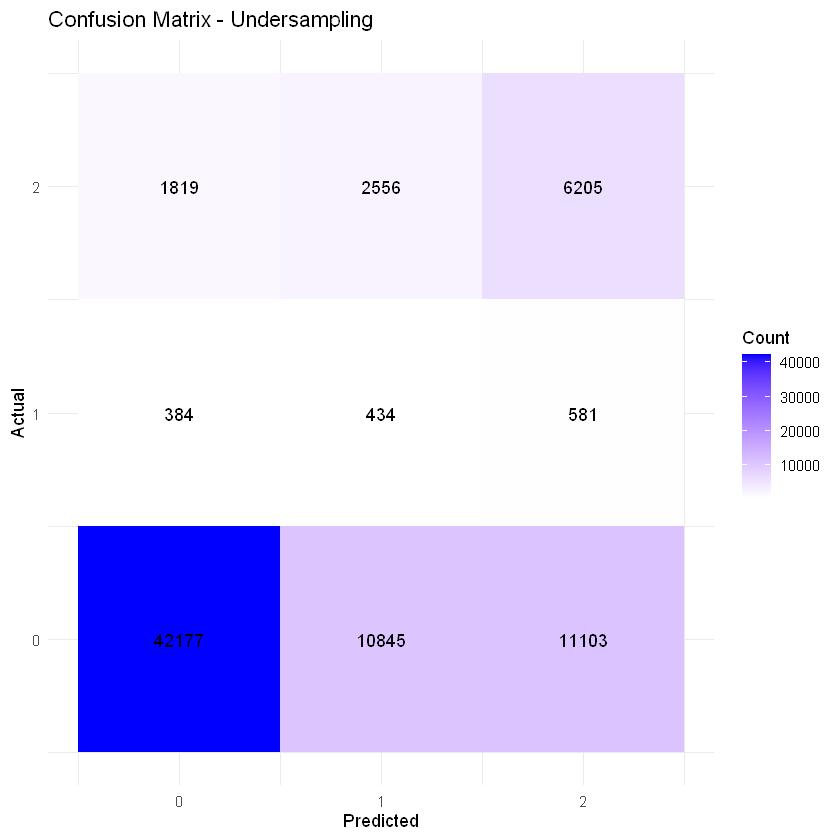

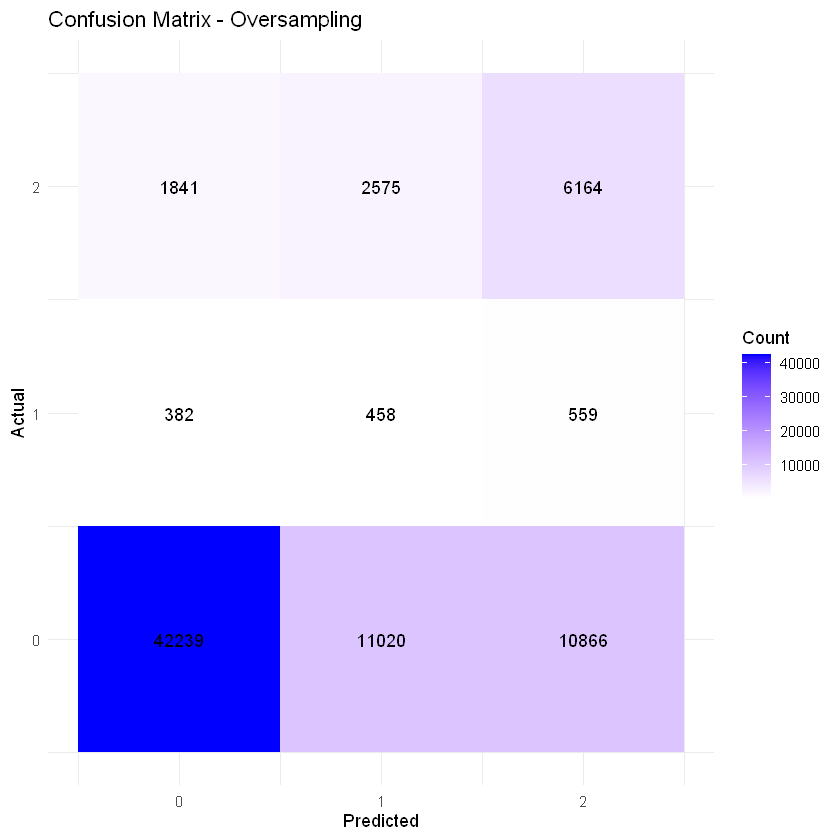

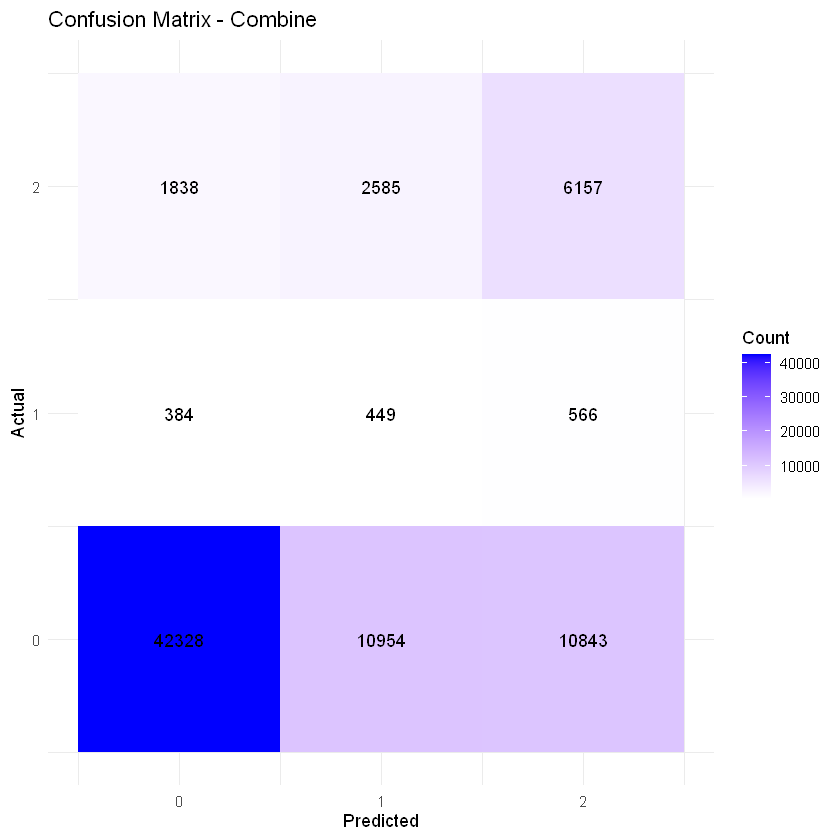

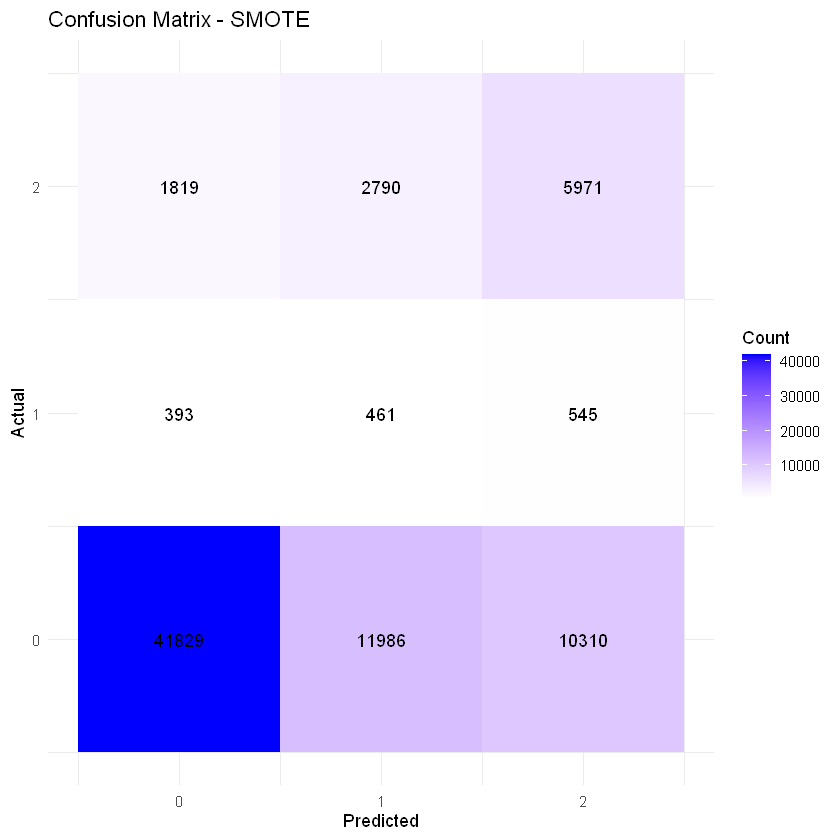

In [18]:
# vẽ trực quan confusion matrix của từng model
sampling_methods <- c("Undersampling", "Oversampling", "Combine", "SMOTE")

for (i in 1:4) {    
    cm <- first_models[[i]]$Confusion_Matrix
    cm_melt <- melt(cm)
    colnames(cm_melt) <- c("Var1", "Var2", "value")
    p <- ggplot(data = cm_melt, aes(x = Var2, y = Var1, fill = value)) +
        geom_tile() +
        geom_text(aes(label = value), color = "black") +
        scale_fill_gradient(low = "white", high = "blue") +
        labs(x = "Predicted", y = "Actual", fill = "Count") +
        ggtitle(paste("Confusion Matrix -", sampling_methods[i])) +
        theme_minimal()

    print(p)
}

Model chạy với train_combine có vẻ cho kết quả tốt nhất trong phân loại nhóm 1 và 2.

#### Chọn biến

In [9]:
# bỏ bớt các biến đa cộng tuyến
formula <- as.formula(
    "Diabetes_012 ~ HighBP + CholCheck + BMI + Stroke + PhysActivity + 
     Fruits + HvyAlcoholConsump + NoDocbcCost + PhysHlth + Income + Sex + Age"
)

In [10]:
# train với train_combine
model_finetune1 <- multinom(formula= formula, data = train_combine, maxit = 1000)

# weights:  42 (26 variable)
initial  value 195087.175773 
iter  10 value 180460.452659
iter  20 value 179021.501422
iter  30 value 173814.724955
final  value 173800.440546 
converged


In [20]:
prop_pred <- predict(model_finetune1, test, type = 'class')
conf_matrix <- table(test$Diabetes_012, prop_pred)
print(eval_multi_class(conf_matrix))

$Precision
         0          1          2 
0.94130224 0.03130574 0.31298568 

$Recall
        0         1         2 
0.6522105 0.2508935 0.6052930 

$Accuracy
[1] 0.6383107

$Kappa
[1] 0.2271445

$Macro_F1
[1] 0.4627039



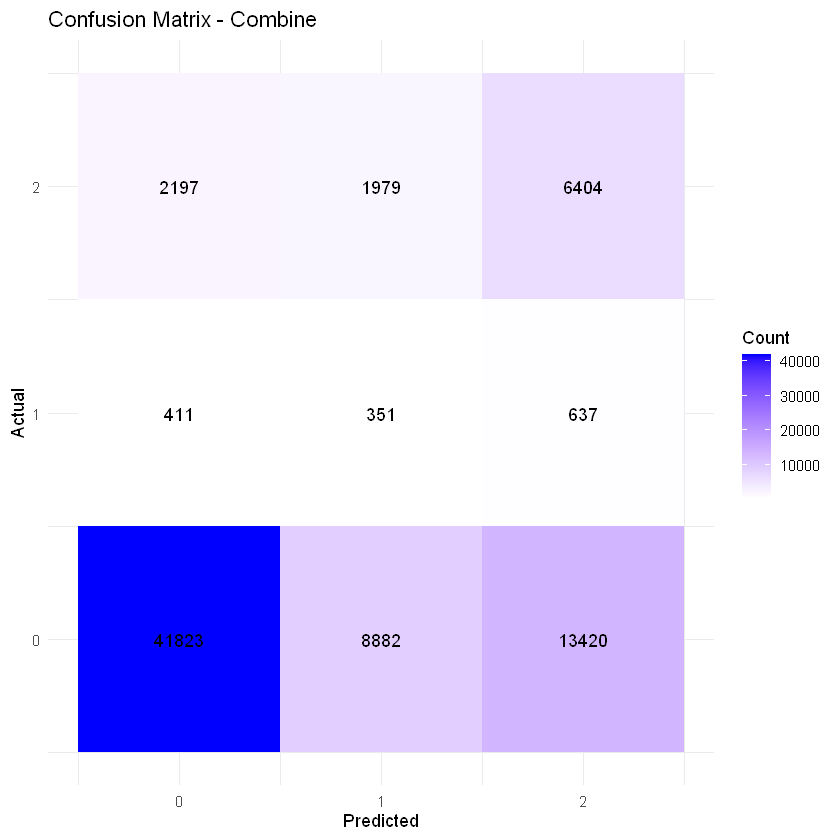

In [21]:
# vẽ biểu đồ confusion matrix
cm_melt <- melt(conf_matrix)
colnames(cm_melt) <- c("Var1", "Var2", "value")
ggplot(data = cm_melt, aes(x = Var2, y = Var1, fill = value)) +
    geom_tile() +
    geom_text(aes(label = value), color = "black") +
    scale_fill_gradient(low = "white", high = "blue") +
    labs(x = "Predicted", y = "Actual", fill = "Count") +
    ggtitle("Confusion Matrix - Combine") +
    theme_minimal()

#### bruh

In [32]:
df_interact <- df_balanced %>% select(-Diabetes_012) 

relations <- data.frame()

for (i in 1:(ncol(df_interact)-1)) {
    for (j in (i+1):(ncol(df_interact)-1)) {
        if (i != j && i != ncol(df_interact) && j != ncol(df_interact)) {
            relations <- rbind(relations, c(colnames(df_interact)[i], colnames(df_interact)[j]))
        }
    }
}

relations <- as.data.frame(relations)
colnames(relations) <- c('var1', 'var2')
head(relations)

,var1,var2
,<chr>,<chr>
1,HighBP,HighChol
2,HighBP,CholCheck
3,HighBP,BMI
4,HighBP,Smoker
5,HighBP,Stroke
6,HighBP,HeartDiseaseorAttack


In [33]:
formula <- as.formula(paste('Diabetes_012 ~ . +', 
    paste(paste(relations$var1, relations$var2, sep = ":"), collapse = " + ")))

In [35]:
model_balanced_formula <- multinom(formula, data = df_balanced, maxit = 1000)

# weights:  639 (424 variable)
initial  value 704330.225781 
iter  10 value 644270.694792
iter  20 value 628077.558169
iter  30 value 622778.736384
iter  40 value 621193.387410
iter  50 value 619734.457212
iter  60 value 618600.514710
iter  70 value 618014.083285
iter  80 value 617702.587476
iter  90 value 617433.122569
iter 100 value 617148.015049
iter 110 value 616851.380789
iter 120 value 616594.555137
iter 130 value 616128.505170
iter 140 value 615404.587297
iter 150 value 613813.334930
iter 160 value 610078.306994
iter 170 value 605814.171901
iter 180 value 603084.560217
iter 190 value 601314.814332
iter 200 value 599938.317785
iter 210 value 598303.340392
iter 220 value 597178.345863
iter 230 value 596220.338304
iter 240 value 595496.041180
iter 250 value 594726.895661
iter 260 value 593846.245643
iter 270 value 593236.683907
iter 280 value 592926.470571
iter 290 value 592705.264185
iter 300 value 592591.794613
iter 310 value 592383.394585
iter 320 value 592142.764056
iter 330 va

In [36]:
prop_pred <- predict(model_balanced_formula, df_balanced, type = 'class')
conf_matrix <- table(df_balanced$Diabetes_012, prop_pred)
conf_matrix 

   prop_pred
         0      1      2
  0 136887  42270  34546
  1  48995  86142  78566
  2  28339  58311 127053

In [37]:
print(eval_multi_class(conf_matrix))

$Precision
        0         1         2 
0.6389990 0.4613358 0.5290238 

$Recall
        0         1         2 
0.6405479 0.4030921 0.5945307 

$Accuracy
[1] 0.5460569

$Kappa
[1] 0.3190854

$Macro_F1
[1] 0.5445843



### Random Forest

In [7]:
library(randomForest)

In [10]:
train_smote$Diabetes_012 <- as.factor(train_smote$Diabetes_012)
model_rf <- randomForest(Diabetes_012 ~ ., data = train_smote, ntree = 100)

In [11]:
predictions <- predict(model_rf, newdata = test)
conf_mt <- table(predicted = predictions, actual = test$Diabetes_012)
print(eval_multi_class(conf_mt))

$Precision
         0          1          2 
0.90300195 0.00571837 0.43081285 

$Recall
         0          1          2 
0.89267270 0.03389831 0.41432597 

$Accuracy
[1] 0.8208636

$Kappa
[1] 0.3153912

$Macro_F1
[1] 0.4467382



In [18]:
# smote dữ liệu rồi mới chia train test:
print(eval_multi_class(conf_mt))

$Precision
        0         1         2 
0.8927715 0.9674409 0.8678677 

$Recall
        0         1         2 
0.8908730 0.9595891 0.8769367 

$Accuracy
[1] 0.9094747

$Kappa
[1] 0.8642105

$Macro_F1
[1] 0.9092465

